<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/tf_estimating_tone_pitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating tone pitch

Pitch is an attribute of musical tones (along with duration, intensity and timbre) that allows you to describe a note as “high” or “low”. Pitch is quantified by **frequency**, measured in **Hertz (Hz)**, where one Hz corresponds to one cycle per second. **The higher the frequency, the higher the note**.

Pitch detection is an interesting challenge. Historically, for a machine to understand pitch, it would need to rely on complex hand-crafted signal-processing algorithms to measure the frequency of a note, in particular to separate the relevant frequency from background noise and backing instruments. Today, we can do that with machine learning, more specifically with the SPICE model (SPICE: Self-Supervised Pitch Estimation).

SPICE is a pretrained model that can recognize the fundamental pitch from mixed audio recordings (including noise and backing instruments).

In [1]:
!sudo apt-get install -qq -y timidity libsndfile1
!pip install -Uqq pydub numba==0.48 librosa music21

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package freepats.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../freepats_20060219-1_all.deb ...
Unpacking freepats (20060219-1) ...
Selecting previously unselected package libaudio2:amd64.
Preparing to unpack .../libaudio2_1.9.4-6_amd64.deb ...
Unpacking libaudio2:amd64 (1.9.4-6) ...
Selecting previously unselected package timidity.
Preparing to unpack .../timidity_2.13.2-41_amd64.deb ...
Unpacking timidity (2.13.2-41) ...
Selecting previously unselected package t

In [2]:
import librosa
import logging
import math
import music21
import statistics
import sys

import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import tensorflow_hub as hub

from librosa import display as librosadisplay
from IPython.display import Audio, Javascript
from scipy.io import wavfile
from base64 import b64decode
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print(f"tensorflow:", tf.__version__)
print(f"librosa:", librosa.__version__)

tensorflow: 2.4.0
librosa: 0.8.0


## Loading the audio file

The model expects raw audio samples as input. To help you with this, we've provide a couple of methods to import your input wav:

- Record a short clip of yourself singing directly in Colab
- Upload a recording from your computer

In [77]:
#@title Loading/Recording the audio file
#@markdown The model expects raw audio samples as input. We've provide
#@markdown a couple of methods to import your input wav:
#@markdown - Record a short clip of yourself singing directly in Colab
#@markdown - Upload a recording from your computer
#@markdown ___
INPUT_SOURCE = "RECORD" #@param ["RECORD", "UPLOAD"] {allow-input: false}

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
    const reader = new FileReader()
    reader.onloadend = e => resolve(e.srcElement.result)
    reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
    stream = await navigator.mediaDevices.getUserMedia({audio: true})
    recorder = new MediaRecorder(stream)
    chunks = []
    recorder.ondataavailable = e => chunks.push(e.data)
    recorder.start()
    await sleep(time)
    recorder.onstop = async () => {
        blob = new Blob(chunks)
        text = await b2text(blob)
        resolve(text)
    }
    recorder.stop()
    stream.getAudioTracks().forEach(track => track.stop())
    stream = null
})
"""

def record(sec=5):
    try:
        from google.colab import output
    except ImportError:
        print("Unable to import colab's output library")
        return ""
    print("Recording ...")
    display(Javascript(RECORD))
    s = output.eval_js(f"record({sec * 1000})")
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(",")[1])
    with open(fname, "wb") as f:
        f.write(b)
    return fname

if INPUT_SOURCE == "RECORD":
    uploaded_file_name = record(15)

Recording ...


<IPython.core.display.Javascript object>

Saving to recorded_audio.wav


## Preparing Audio Data

The SPICE model needs as input an audio file at a sampling rate of 16kHz and with only one channel (mono).


In [78]:
EXPECTED_SAMPLE_RATE = 16000
def convert_audio_for_model(user_file, output_file="converted_audio.wav"):
    """
    Converts the user provided audio to the format expected by the SPICE model.
    """
    audio = AudioSegment.from_file(user_file)
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file

In [80]:
converted_audio_file = convert_audio_for_model(uploaded_file_name)

In [81]:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

assert sample_rate == EXPECTED_SAMPLE_RATE

duration = len(audio_samples) / sample_rate
print(f"Sample rate: {sample_rate} Hz")
print(f"Total duration: {duration:.2f}s")
print(f"Size of the input: {len(audio_samples):,}")

Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 14.94s
Size of the input: 239,040


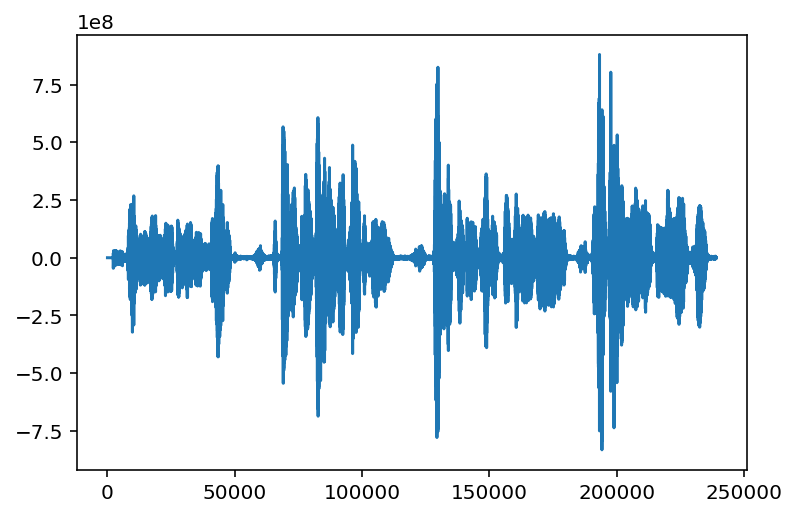

In [82]:
plt.plot(audio_samples);

A more informative visualization is the spectogram, which shows frequencies present over time. Here, we use a logaritmic frequency scale to make the signing clearer.

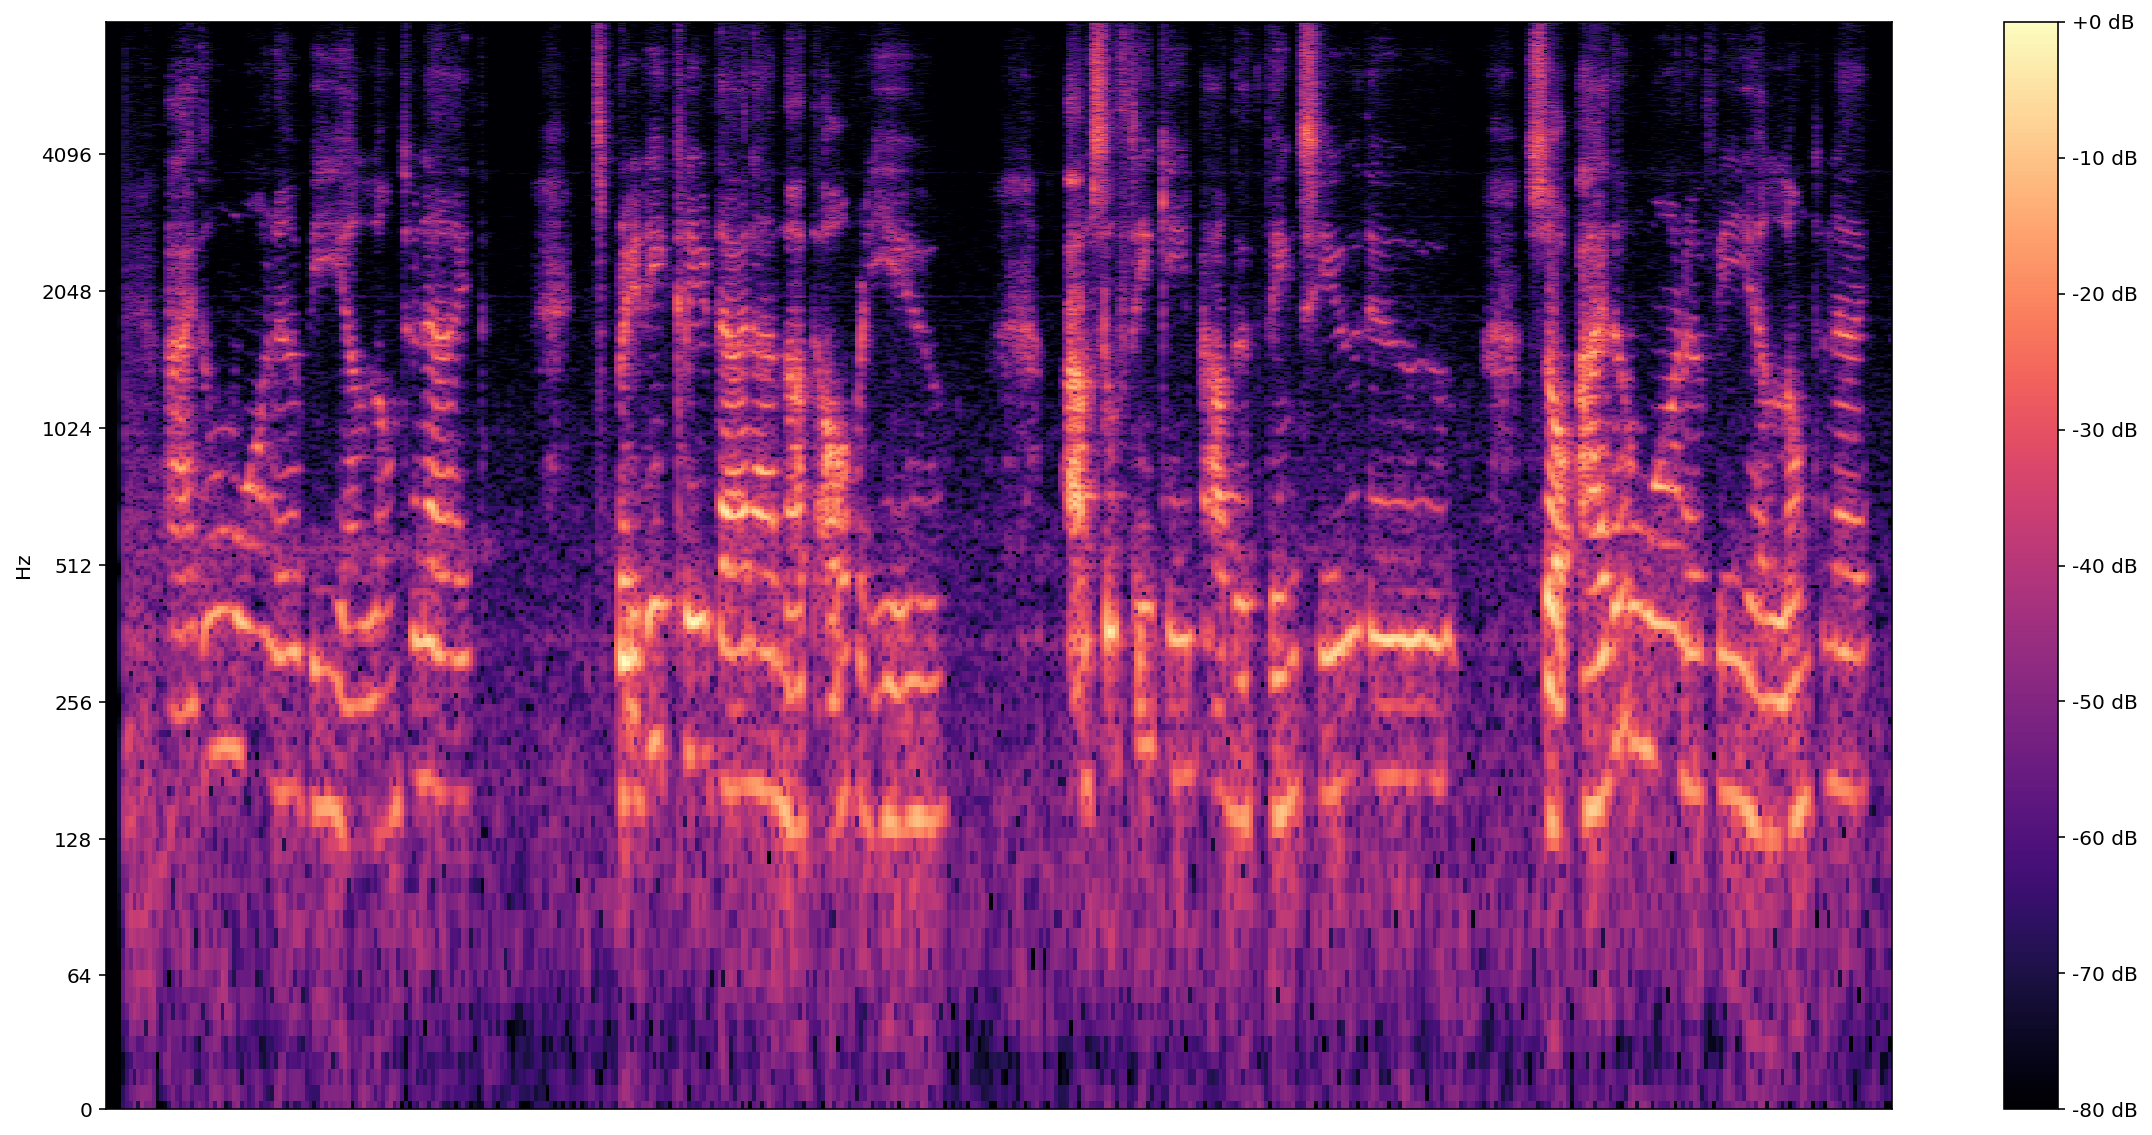

In [83]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
    x_stft = np.abs(librosa.stft(x, n_fft=2048))
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
    if show_black_and_white:
        librosadisplay.specshow(
            data=x_stft_db, y_axis='log', sr=sample_rate, cmap='gray_r'
        )
    else:
        librosadisplay.specshow(data=x_stft_db, y_axis='log', sr=sample_rate)
    
    plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16, sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()


The audio samples are in int16 and they need to be normalized between -1 and 1.

In [84]:
audio_samples = audio_samples / float(MAX_ABS_INT16)

## Executing the Model

In [85]:
model = hub.load("https://tfhub.dev/google/spice/2")

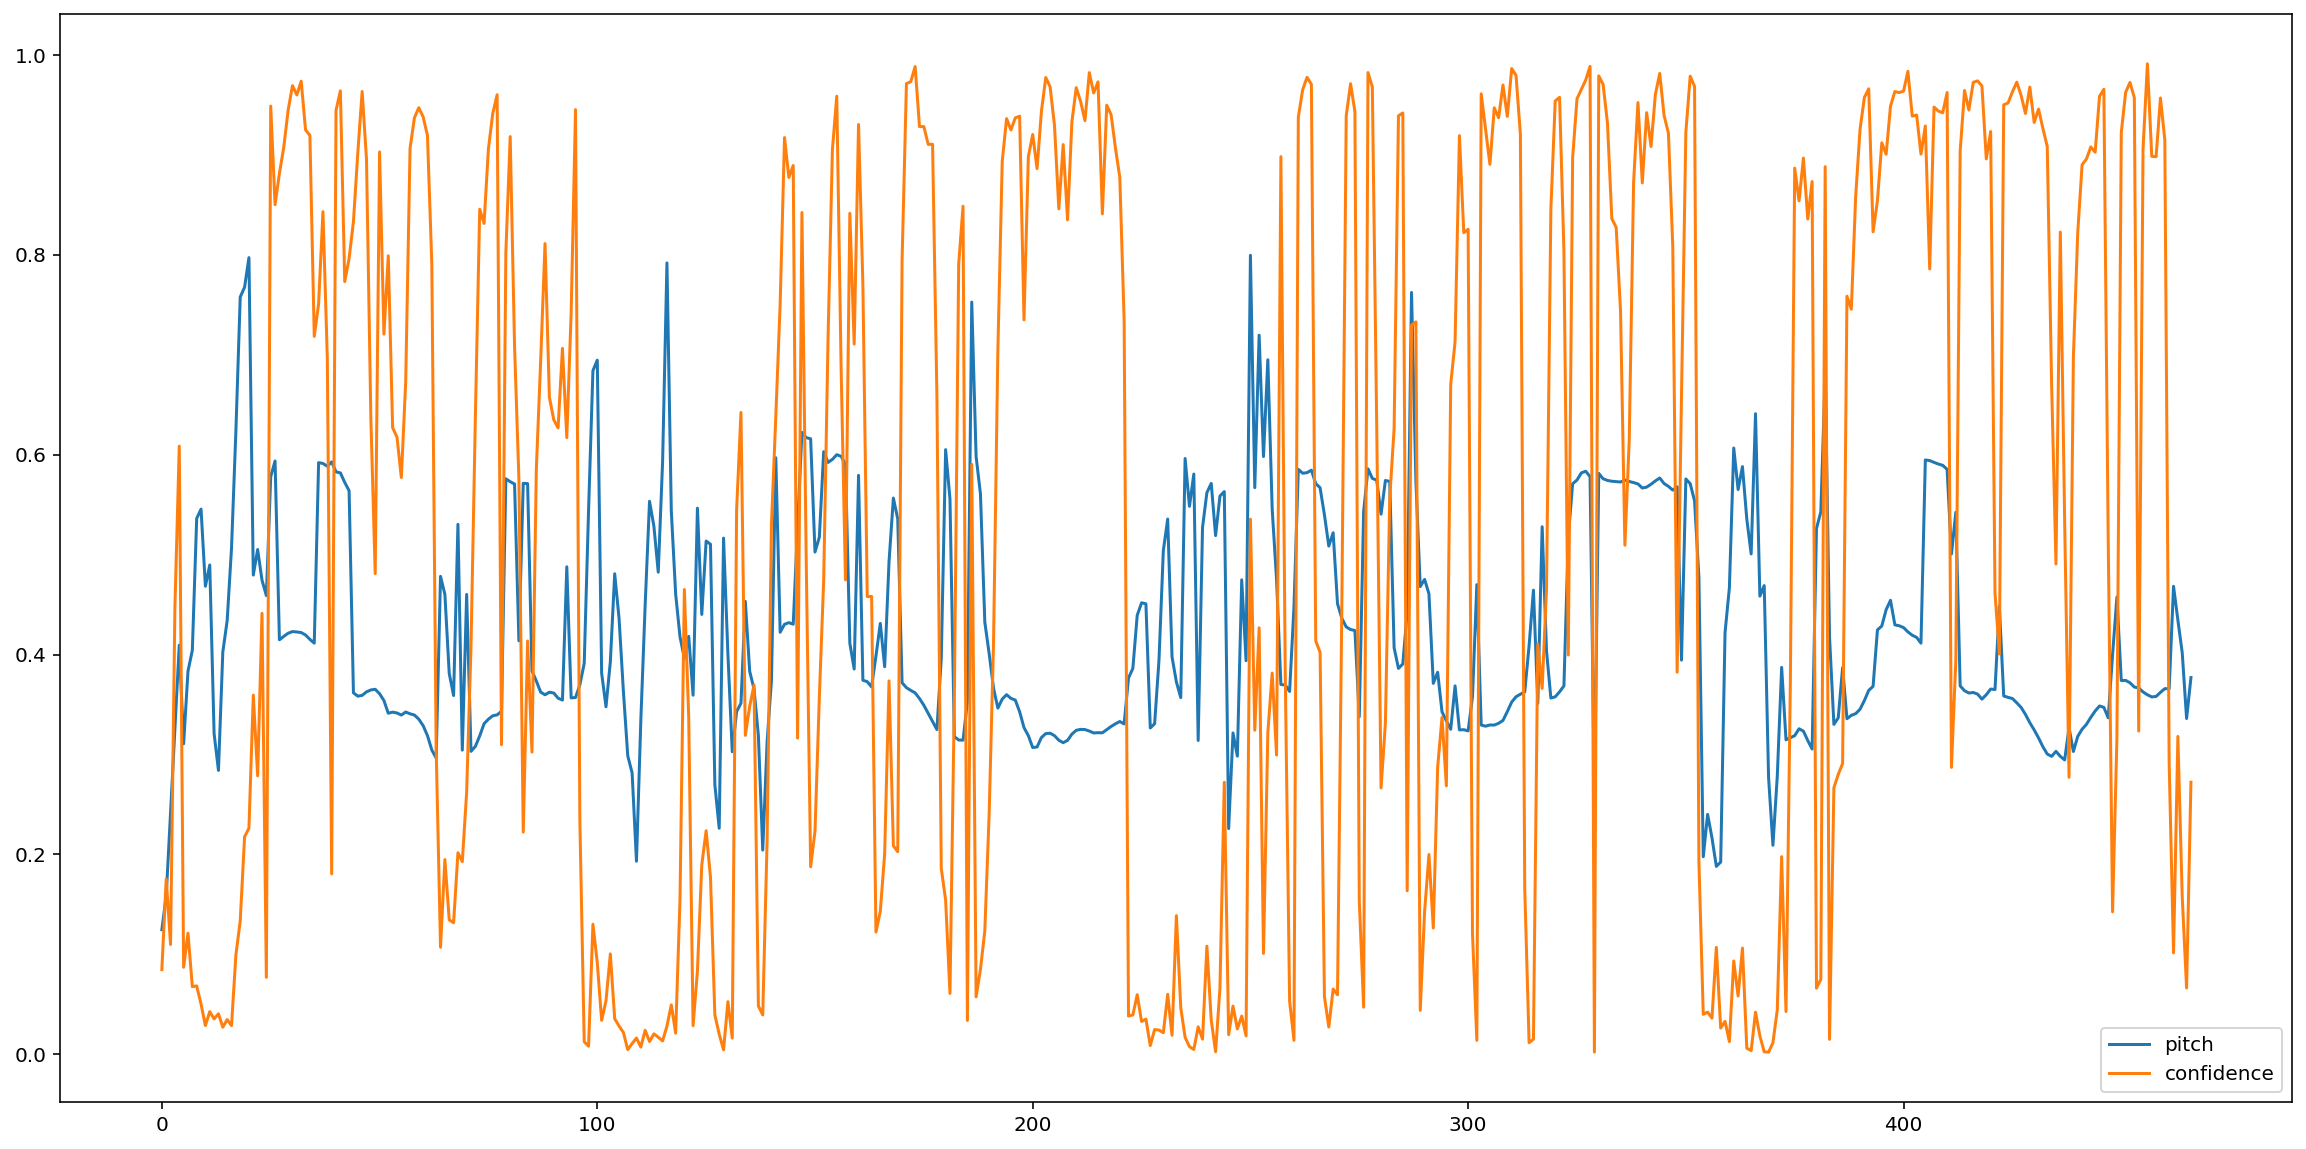

In [86]:
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

Let's make the results easier to understand by removing all pitch estimates with low confidence.

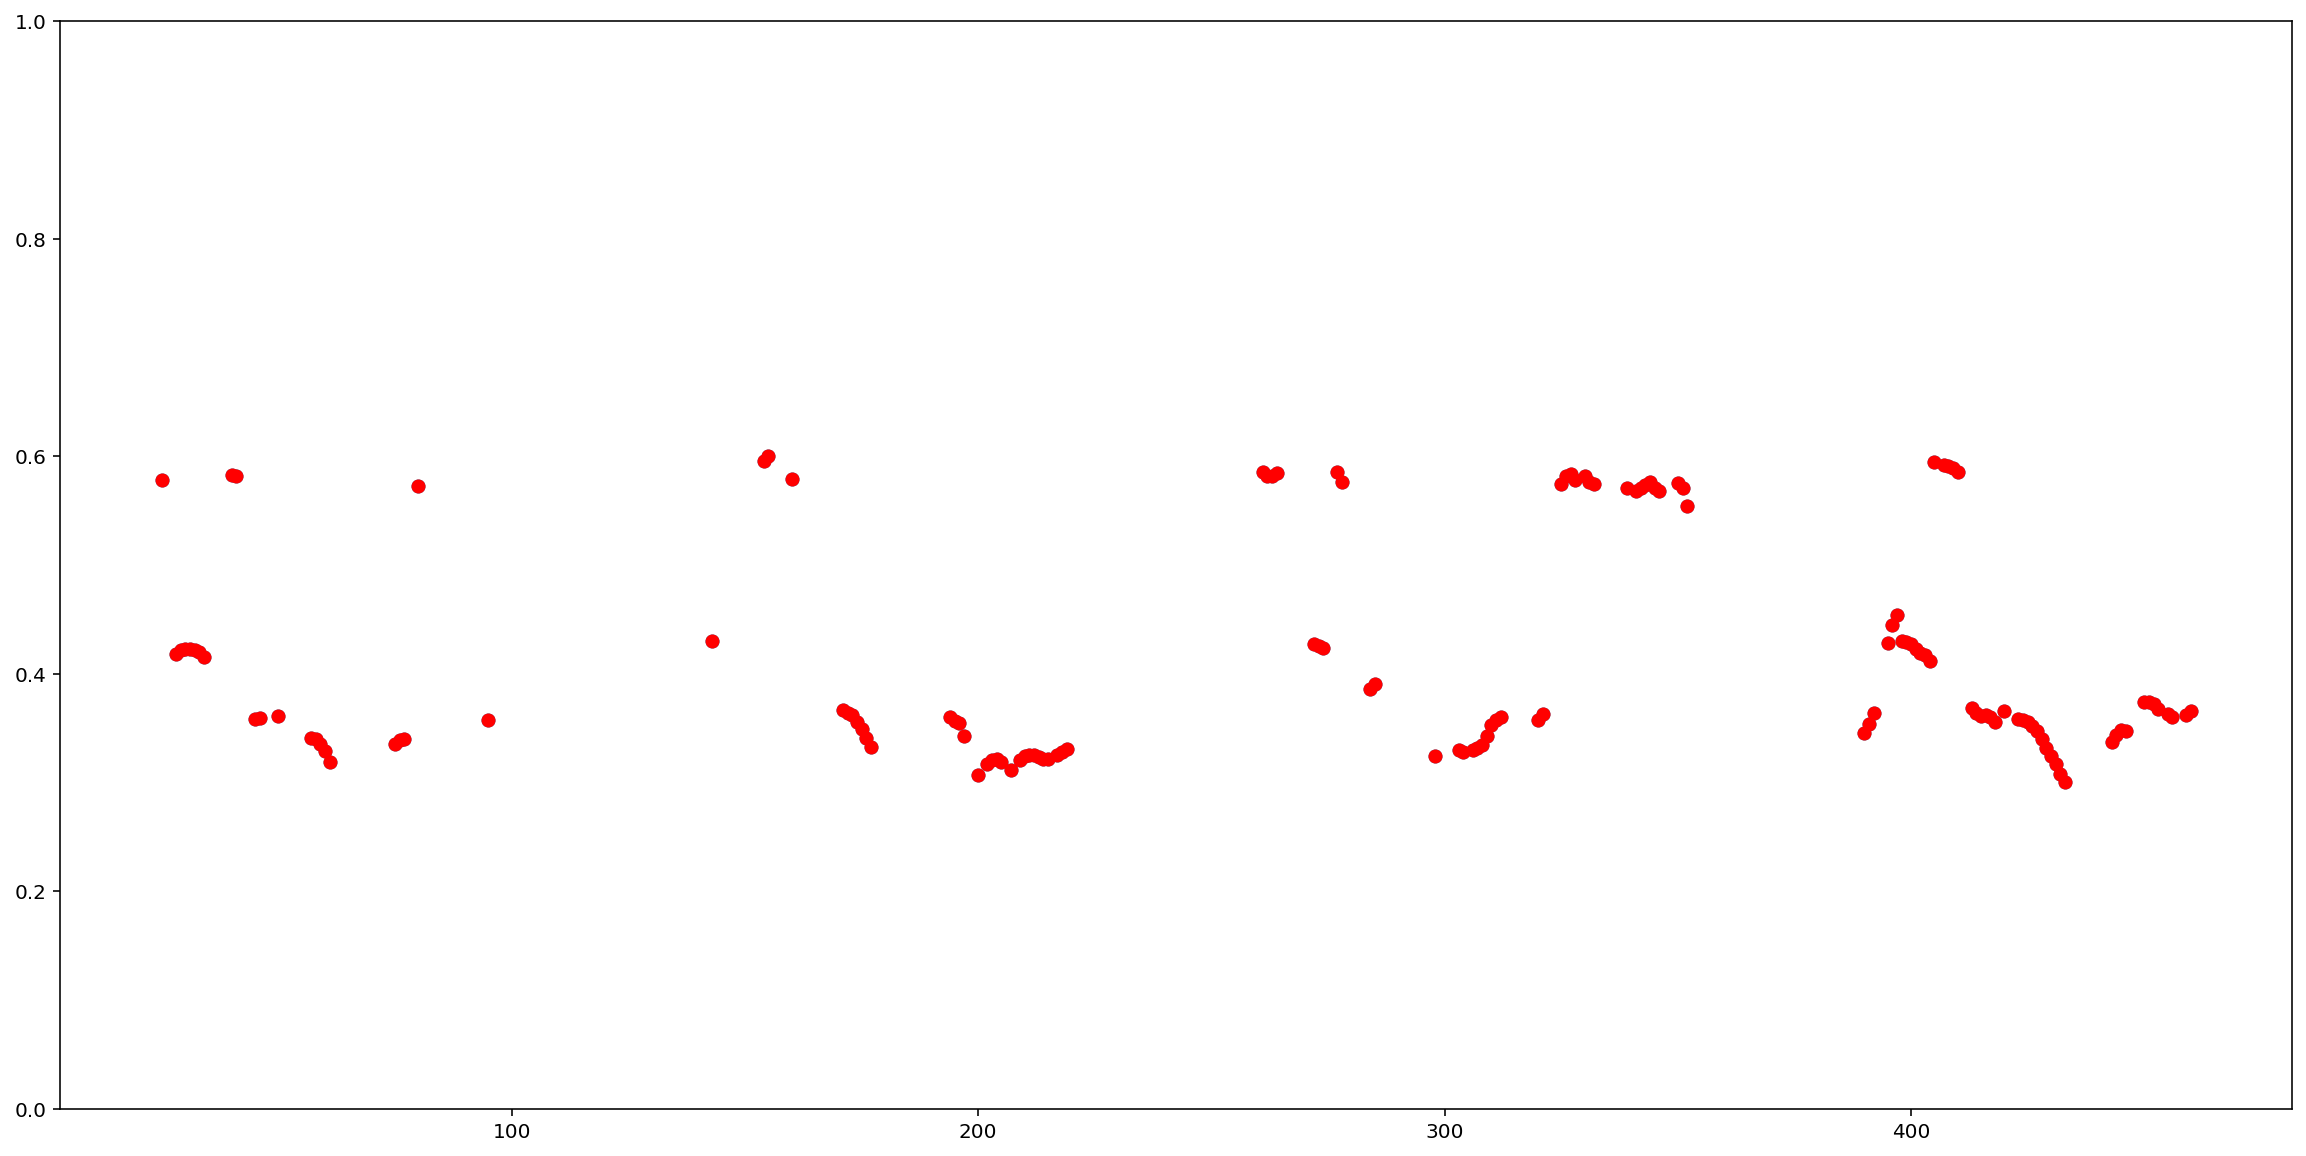

In [87]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
 
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

plt.show()

The pitch values returned by SPICE are in the range from 0 to 1. Let's convert them to absolute pitch values in Hz.

In [88]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)
    
confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

Now, let's see how good the prediction is: We will overlay the predicted pitches over the original spectrogram. To make the pitch predictions more visible, we changed the spectrogram to black and white.

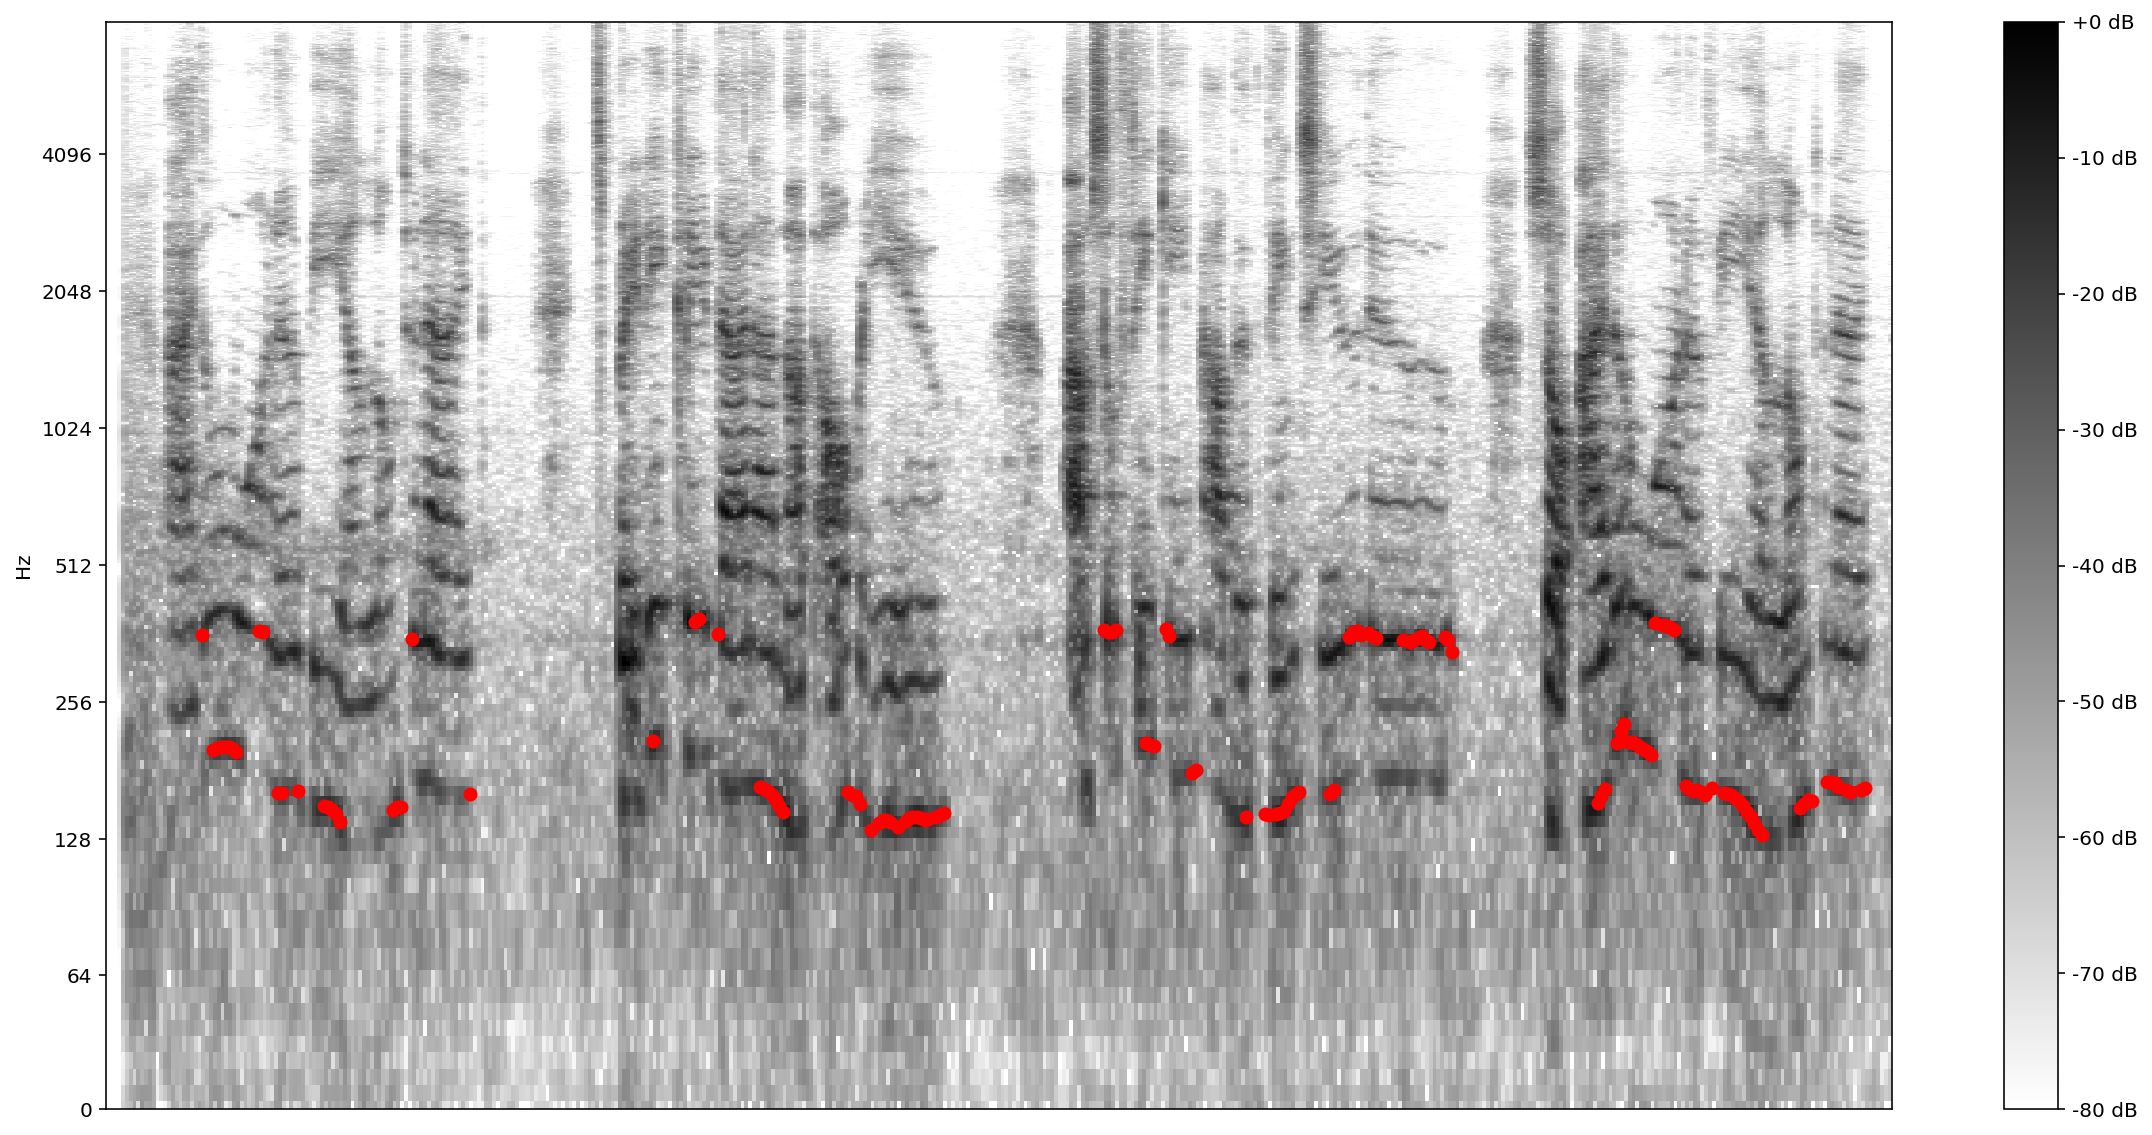

In [89]:
plot_stft(audio_samples / MAX_ABS_INT16 , 
          sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
# Note: conveniently, since the plot is in log scale, the pitch outputs 
# also get converted to the log scale automatically by matplotlib.
plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")

plt.show()

# Converting to musical notes

Now that we have the pitch values, let's convert them to notes!
This is part is challenging by itself. We have to take into account two things:
1. the rests (when there's no singing) 
2. the size of each note (offsets) 

In [90]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

In [91]:
A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def hz2offset(freq):
  # This measures the quantization error for a single note.
  if freq == 0:  # Rests always have zero error.
    return None
  # Quantized note.
  h = round(12 * math.log2(freq / C0))
  return 12 * math.log2(freq / C0) - h


# The ideal offset is the mean quantization error for all the notes
# (excluding rests):
offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)

offsets:  [-0.473670159416848, 0.4447293491786297, -0.35697506381814037, -0.2524637390548463, -0.27817899091785137, -0.31359314634148205, -0.46768353684490194, 0.25473985807354893, -0.16730886264387834, -0.2356410215670266, -0.33000873132292696, -0.2790669320399033, -0.17450861646477733, -0.4441552407914884, 0.47911816166097765, 0.2196480561917582, -0.18729989274089576, 0.17669826553518675, 0.21617637501414322, 0.43403705642873547, 0.4882306198900537, 0.20969823197777515, -0.4164361120635718, 0.2086138658350194, -0.3804308019453799, -0.08527587397639991, -0.3869326393181609, 0.20638198749478676, 0.03332422570641569, -0.12187138869111891, -0.48109546913450174, 0.09553235338384525, -0.41916364743058665, 0.05912744299823913, -0.2337020023042342, -0.47091162039582457, 0.42376317398006336, -0.3191784776622484, 0.42662716792280264, 0.05774008558447008, 0.30820111261065364, 0.33056310014183055, 0.1770986272519366, -0.2663912565881432, 0.27331701354439275, -0.48588514997307897, -0.426377865510

In [92]:
def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  # Create a rest if 80% is silent, otherwise create a note.
  if zero_values_count > 0.8 * len(group):
    # Interpret as a rest. Count each dropped note as an error, weighted a bit
    # worse than a badly sung note (which would 'cost' 0.5).
    return 0.51 * len(non_zero_values), "Rest"
  else:
    # Interpret as note, estimating as mean of non-rest predictions.
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    # Quantization error is the total difference from the quantized note.
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])
    return error, note


def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  # Apply the start offset - we can just add the offset as rests.
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  # Collect the predictions for each note (or rest).
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests


best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
  for prediction_start_offset in range(predictions_per_note):

    error, notes_and_rests = get_quantization_and_error(
        pitch_outputs_and_rests, predictions_per_note,
        prediction_start_offset, ideal_offset)

    if error < best_error:      
      best_error = error
      best_notes_and_rests = notes_and_rests
      best_predictions_per_note = predictions_per_note

# At this point, best_notes_and_rests contains the best quantization.
# Since we don't need to have rests at the beginning, let's remove these:
while best_notes_and_rests[0] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[1:]
# Also remove silence at the end.
while best_notes_and_rests[-1] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[:-1]

In [93]:
# Creating the sheet music score.
sc = music21.stream.Score()
# Adjust the speed to match the actual singing.
bpm = 60 * 60 / best_predictions_per_note
print ('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0,a)

for snote in best_notes_and_rests:   
    d = 'half'
    if snote == 'Rest':      
      sc.append(music21.note.Rest(type=d))
    else:
      sc.append(music21.note.Note(snote, type=d))

bpm:  156.52173913043478


In [94]:
#@title [Run this] Helper function to use Open Sheet Music Display (JS code) to show a music score

from IPython.core.display import display, HTML, Javascript
import json, random

def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)
    
def showMusicXML(xml):
    DIV_ID = "OSMD_div"
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    script = """
    var div_id = {{DIV_ID}};
    function loadOSMD() { 
        return new Promise(function(resolve, reject){
            if (window.opensheetmusicdisplay) {
                return resolve(window.opensheetmusicdisplay)
            }
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
          drawingParameters: "compacttight"
        });
        openSheetMusicDisplay
            .load({{data}})
            .then(
              function() {
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
    display(Javascript(script))
    return

In [95]:
# rendering the music score
showScore(sc)
print(best_notes_and_rests)

<IPython.core.display.Javascript object>

['A3', 'D3', 'Rest', 'Rest', 'Rest', 'Rest', 'D#3', 'D3', 'D3', 'Rest', 'D#4', 'Rest', 'D#3', 'F4', 'Rest', 'Rest', 'A#3', 'D#3', 'E3']


In [96]:
# Saving the recognized musical notes as a MIDI file
converted_audio_file_as_midi = converted_audio_file[:-4] + '.mid'
fp = sc.write('midi', fp=converted_audio_file_as_midi)

wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
print(wav_from_created_midi)

converted_audio.mid_midioutput.wav


In [97]:
!timidity $converted_audio_file_as_midi -Ow -o $wav_from_created_midi

Playing converted_audio.mid
MIDI file: converted_audio.mid
Format: 1  Tracks: 1  Divisions: 1024
Sequence: 
Playing time: ~18 seconds
Notes cut: 0
Notes lost totally: 0


In [99]:
Audio(wav_from_created_midi)